In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap


import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-virussign-vgg16-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = VGG16(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)                           
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]                            

    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 177s - loss: 13.8168 - acc: 0.1378 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 2/100
9112/9112 [==============================] - 180s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 3/100
9112/9112 [==============================] - 187s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 4/100
9112/9112 [==============================] - 138s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 5/100
9112/9112 [==============================] - 126s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 6/100
9112/9112 [==============================] - 134s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 7/100
9112/9112 [==============================] - 126s - loss: 13.8893 - acc: 0.1383 - val_loss: 13.8987 - val_acc: 0.1377
Epoch 8/100
9112/9112 [===================

9114/9114 [==============================] - 131s - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 25/100
9114/9114 [==============================] - 130s - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 26/100
9114/9114 [==============================] - 130s - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 27/100
9114/9114 [==============================] - 131s - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 28/100
9114/9114 [==============================] - 132s - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 29/100
9114/9114 [==============================] - 132s - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 30/100
9114/9114 [==============================] - 132s - loss: 15.7060 - acc: 0.0256 - val_loss: 15.7080 - val_acc: 0.0254
Epoch 31/100
9114/9114 [==============================] - 133s - loss: 15.7060 - acc: 0.0256 - v

9116/9116 [==============================] - 130s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 48/100
9116/9116 [==============================] - 129s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 49/100
9116/9116 [==============================] - 130s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 50/100
9116/9116 [==============================] - 130s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 51/100
9116/9116 [==============================] - 131s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 52/100
9116/9116 [==============================] - 130s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 53/100
9116/9116 [==============================] - 129s - loss: 13.8885 - acc: 0.1383 - val_loss: 13.9058 - val_acc: 0.1373
Epoch 54/100
9116/9116 [==============================] - 129s - loss: 13.8885 - acc: 0.1383 - v

9120/9120 [==============================] - 130s - loss: 14.7449 - acc: 0.0852 - val_loss: 14.7538 - val_acc: 0.0846
Epoch 71/100
9120/9120 [==============================] - 129s - loss: 14.7449 - acc: 0.0852 - val_loss: 14.7538 - val_acc: 0.0846
Epoch 72/100
9120/9120 [==============================] - 128s - loss: 14.7449 - acc: 0.0852 - val_loss: 14.7538 - val_acc: 0.0846
Epoch 73/100
9120/9120 [==============================] - 130s - loss: 14.7449 - acc: 0.0852 - val_loss: 14.7538 - val_acc: 0.0846
Epoch 74/100
9120/9120 [==============================] - 130s - loss: 14.7449 - acc: 0.0852 - val_loss: 14.7538 - val_acc: 0.0846
Epoch 75/100
9120/9120 [==============================] - 129s - loss: 14.7449 - acc: 0.0852 - val_loss: 14.7538 - val_acc: 0.0846
Epoch 76/100
9120/9120 [==============================] - 130s - loss: 14.7449 - acc: 0.0852 - val_loss: 14.7538 - val_acc: 0.0846
Epoch 77/100
9120/9120 [==============================] - 129s - loss: 14.7449 - acc: 0.0852 - v

9120/9120 [==============================] - 131s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 94/100
9120/9120 [==============================] - 133s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 95/100
9120/9120 [==============================] - 129s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 96/100
9120/9120 [==============================] - 133s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 97/100
9120/9120 [==============================] - 133s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 98/100
9120/9120 [==============================] - 132s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 99/100
9120/9120 [==============================] - 132s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 100/100
1016/1016 [==============================] - 6s     
[4] Test acurracy: 0.1378 (13

9127/9127 [==============================] - 132s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 16/100
9127/9127 [==============================] - 132s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 17/100
9127/9127 [==============================] - 131s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 18/100
9127/9127 [==============================] - 133s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 19/100
9127/9127 [==============================] - 132s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 20/100
9127/9127 [==============================] - 133s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 21/100
9127/9127 [==============================] - 132s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 22/100
9127/9127 [==============================] - 132s - loss: 13.8912 - acc: 0.1382 - v

9128/9128 [==============================] - 130s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 39/100
9128/9128 [==============================] - 130s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 40/100
9128/9128 [==============================] - 131s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 41/100
9128/9128 [==============================] - 131s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 42/100
9128/9128 [==============================] - 132s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 43/100
9128/9128 [==============================] - 132s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 44/100
9128/9128 [==============================] - 147s - loss: 13.8914 - acc: 0.1381 - val_loss: 13.8795 - val_acc: 0.1389
Epoch 45/100
9128/9128 [==============================] - 177s - loss: 13.8914 - acc: 0.1381 - v

9130/9130 [==============================] - 132s - loss: 15.3148 - acc: 0.0498 - val_loss: 15.3170 - val_acc: 0.0497
Epoch 62/100
9130/9130 [==============================] - 129s - loss: 15.3148 - acc: 0.0498 - val_loss: 15.3170 - val_acc: 0.0497
Epoch 63/100
9130/9130 [==============================] - 131s - loss: 15.3148 - acc: 0.0498 - val_loss: 15.3170 - val_acc: 0.0497
Epoch 64/100
9130/9130 [==============================] - 130s - loss: 15.3148 - acc: 0.0498 - val_loss: 15.3170 - val_acc: 0.0497
Epoch 65/100
9130/9130 [==============================] - 130s - loss: 15.3148 - acc: 0.0498 - val_loss: 15.3170 - val_acc: 0.0497
Epoch 66/100
9130/9130 [==============================] - 130s - loss: 15.3148 - acc: 0.0498 - val_loss: 15.3170 - val_acc: 0.0497
Epoch 67/100
9130/9130 [==============================] - 131s - loss: 15.3148 - acc: 0.0498 - val_loss: 15.3170 - val_acc: 0.0497
Epoch 68/100
9130/9130 [==============================] - 131s - loss: 15.3148 - acc: 0.0498 - v

9132/9132 [==============================] - 106s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 85/100
9132/9132 [==============================] - 106s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 86/100
9132/9132 [==============================] - 106s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 87/100
9132/9132 [==============================] - 106s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 88/100
9132/9132 [==============================] - 106s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 89/100
9132/9132 [==============================] - 105s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 90/100
9132/9132 [==============================] - 105s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 91/100
9132/9132 [==============================] - 105s - loss: 13.8924 - acc: 0.1381 - v

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.1128


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

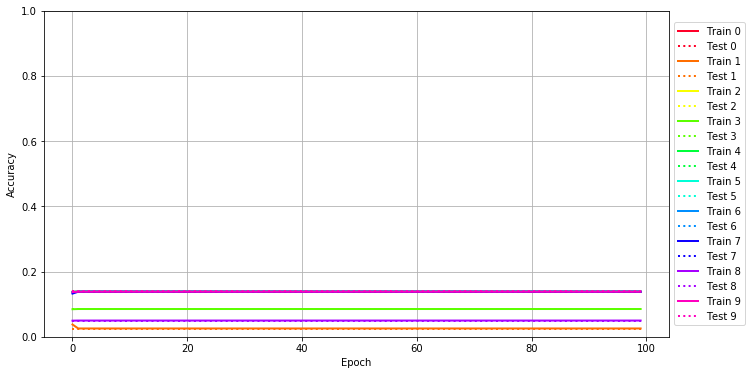

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

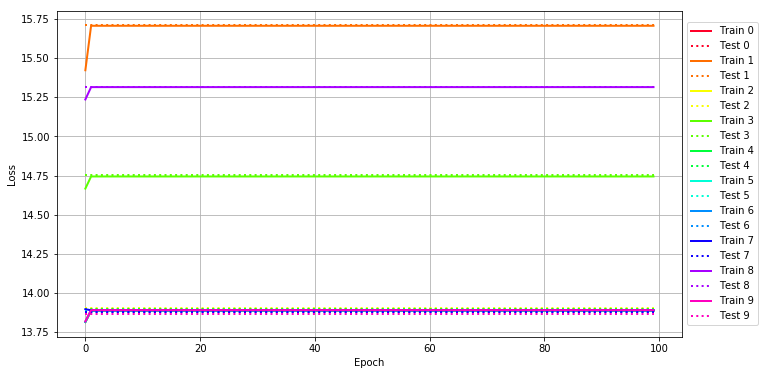

In [12]:
plot_loss(history)

Plotting the confusion matrix


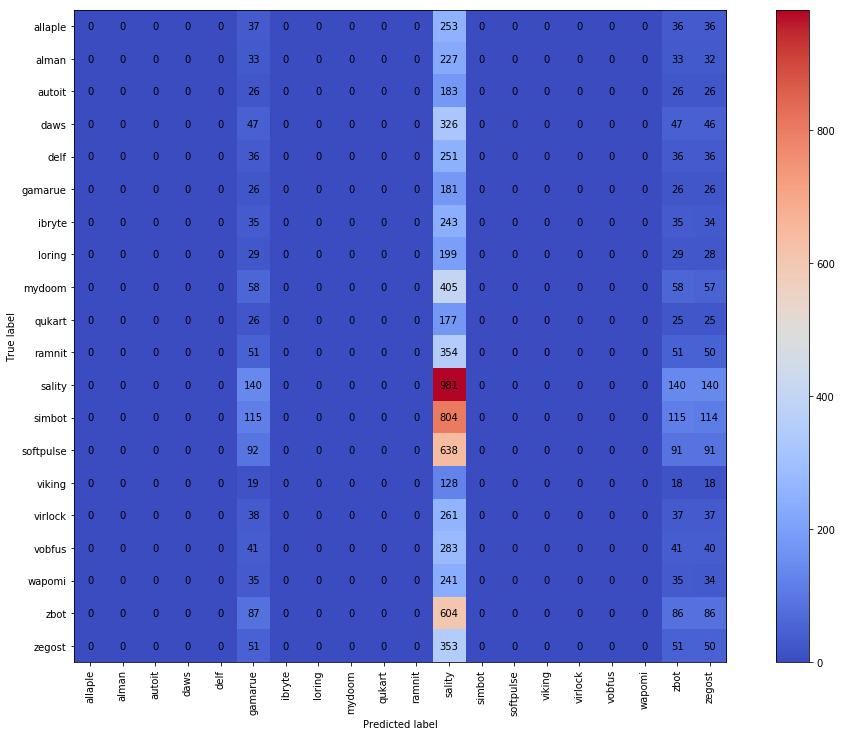

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


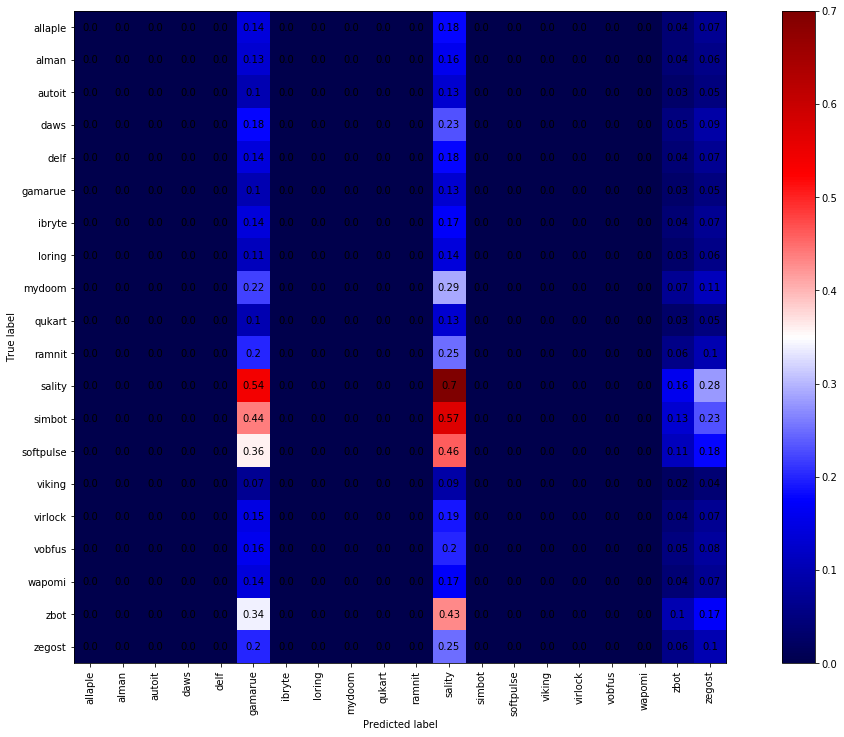

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


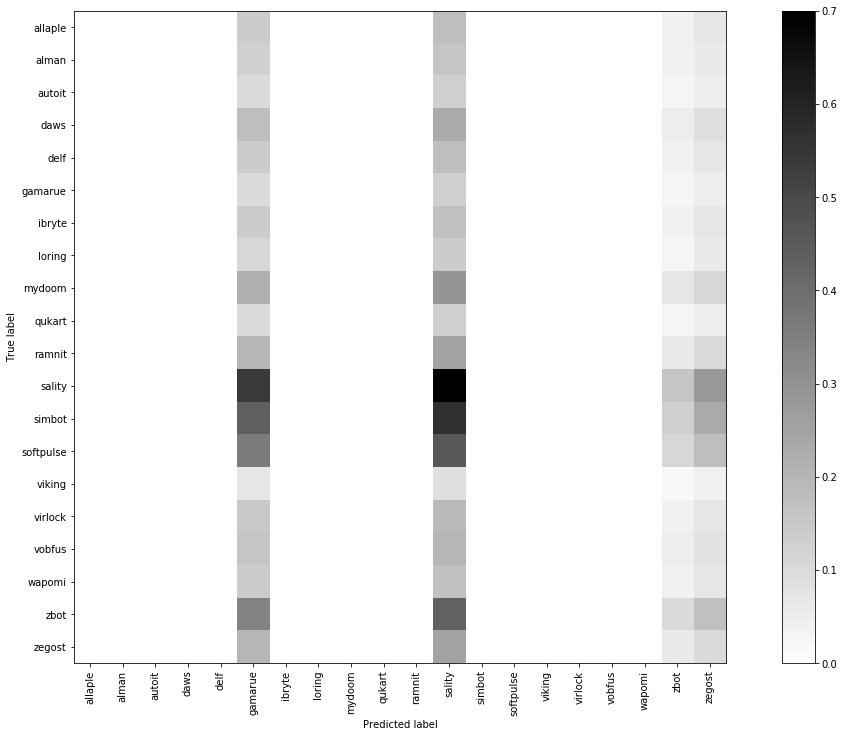

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


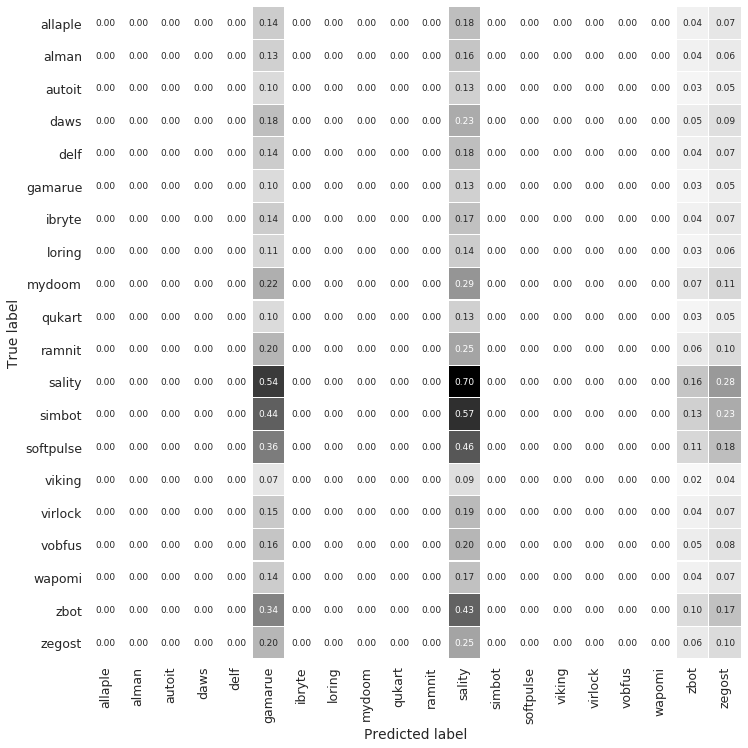

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'loss': [13.816790868777575, 13.889298217981086, 13.889298120018053, 13.88929814681136, 13.88929822216754, 13.889298123367215, 13.889298139275743, 13.889298213794632, 13.889298151835106, 13.889298151835106, 13.889298226353995, 13.889298238913359, 13.889298197048813, 13.889298123367215, 13.889298207096305, 13.889298170255506, 13.889298158533434, 13.889298200397977, 13.889298131740125, 13.889298213794632, 13.889298152672398, 13.889298143462197, 13.889298198723395, 13.889298133414707, 13.88929819369965, 13.889298091550161, 13.889298160208014, 13.889298148485942, 13.889298113319725, 13.889298176953833, 13.889298150160524, 13.889298171930086, 13.889298198723395, 13.889298116668888, 13.889298173604669, 13.88929814681136, 13.889298125041798, 13.889298140113034, 13.889298195374232, 13.88929818365216, 13.889298166906341, 13.88929811834347, 13.889298145136779, 13.889298165231759, 13.889298220492959, 13.88929818365216, 13.889298185326741, 13.889298150160524, 13.889298131740125, 13.88929812671638

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

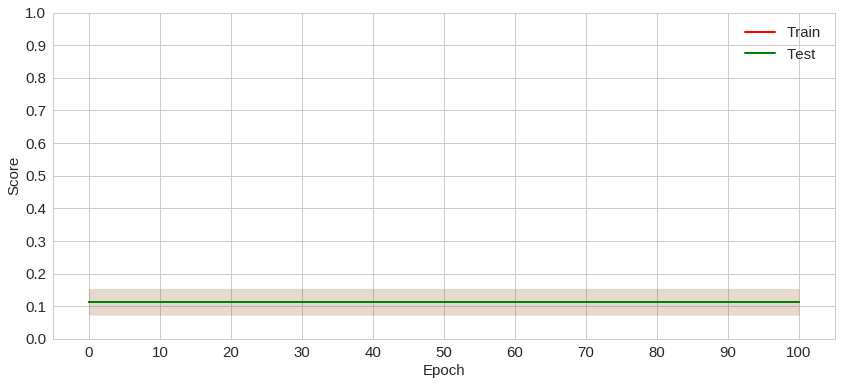

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

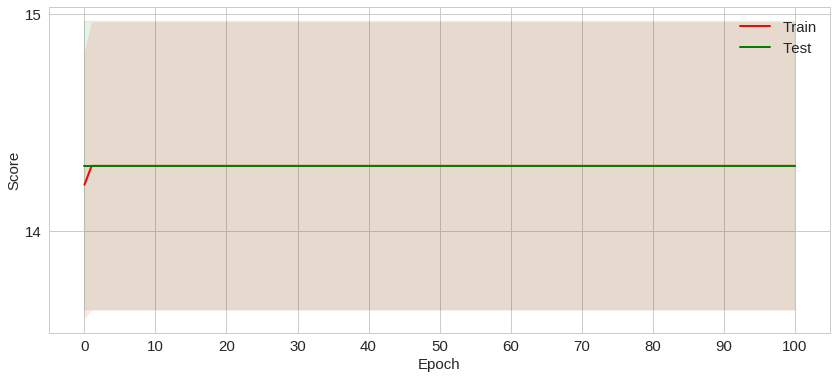

In [21]:
plot_mean_loss(history)

In [1]:
history = [{'loss': [13.816790868777575, 13.889298217981086, 13.889298120018053, 13.88929814681136, 13.88929822216754, 13.889298123367215, 13.889298139275743, 13.889298213794632, 13.889298151835106, 13.889298151835106, 13.889298226353995, 13.889298238913359, 13.889298197048813, 13.889298123367215, 13.889298207096305, 13.889298170255506, 13.889298158533434, 13.889298200397977, 13.889298131740125, 13.889298213794632, 13.889298152672398, 13.889298143462197, 13.889298198723395, 13.889298133414707, 13.88929819369965, 13.889298091550161, 13.889298160208014, 13.889298148485942, 13.889298113319725, 13.889298176953833, 13.889298150160524, 13.889298171930086, 13.889298198723395, 13.889298116668888, 13.889298173604669, 13.88929814681136, 13.889298125041798, 13.889298140113034, 13.889298195374232, 13.88929818365216, 13.889298166906341, 13.88929811834347, 13.889298145136779, 13.889298165231759, 13.889298220492959, 13.88929818365216, 13.889298185326741, 13.889298150160524, 13.889298131740125, 13.88929812671638, 13.889298165231759, 13.889298158533434, 13.889298131740125, 13.889298166906341, 13.889298135089287, 13.889298113319725, 13.889298150997815, 13.889298178628414, 13.889298225516704, 13.889298185326741, 13.889298177791122, 13.889298165231759, 13.889298178628414, 13.889298124204506, 13.889298140950324, 13.88929814597407, 13.889298166906341, 13.889298176953833, 13.889298143462197, 13.889298119180761, 13.889298155184269, 13.889298134251998, 13.88929816606905, 13.889298173604669, 13.889298165231759, 13.889298140113034, 13.88929821212005, 13.889298185326741, 13.889298198723395, 13.889298130065542, 13.889298099923071, 13.889298141787615, 13.889298160208014, 13.889298199560686, 13.889298213794632, 13.88929821212005, 13.889298247286266, 13.889298192025068, 13.88929811834347, 13.889298187001323, 13.889298208770885, 13.889298198723395, 13.889298131740125, 13.889298153509687, 13.889298176953833, 13.889298139275743, 13.889298198723395, 13.889298197048813, 13.889298152672398, 13.889298159370723], 'val_acc': [0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125, 0.1376953125], 'acc': [0.1378402107242328, 0.13827919227392449, 0.13827919227392449, 0.13827919227392449, 0.13827919232625518, 0.13827919227719515, 0.13827919228700716, 0.13827919227392449, 0.13827919230008984, 0.13827919228046584, 0.13827919228700716, 0.13827919228046584, 0.13827919227719515, 0.13827919227719515, 0.13827919227392449, 0.13827919227719515, 0.13827919230008984, 0.13827919227392449, 0.13827919228046584, 0.13827919227392449, 0.13827919228700716, 0.13827919227719515, 0.13827919228046584, 0.13827919227392449, 0.13827919227392449, 0.13827919230008984, 0.13827919227392449, 0.13827919232625518, 0.13827919227392449, 0.13827919227719515, 0.13827919227719515, 0.13827919230008984, 0.13827919228046584, 0.13827919230008984, 0.13827919227392449, 0.13827919227392449, 0.13827919228046584, 0.13827919227392449, 0.13827919232625518, 0.13827919227719515, 0.13827919227392449, 0.13827919228046584, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919227719515, 0.13827919228046584, 0.13827919227719515, 0.13827919230008984, 0.13827919227392449, 0.13827919228046584, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919232625518, 0.13827919227392449, 0.13827919227392449, 0.13827919230008984, 0.13827919230008984, 0.13827919230008984, 0.13827919227392449, 0.13827919230008984, 0.13827919230008984, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919227392449, 0.13827919227719515, 0.13827919227719515, 0.13827919228700716, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919227392449, 0.13827919228046584, 0.13827919227392449, 0.13827919228046584, 0.13827919230008984, 0.13827919228046584, 0.13827919227719515, 0.13827919227392449, 0.13827919232625518, 0.13827919227392449, 0.13827919228700716, 0.13827919227392449, 0.13827919228046584, 0.13827919227392449, 0.13827919228046584, 0.13827919228046584, 0.13827919227392449, 0.13827919232625518, 0.13827919228046584, 0.13827919230008984, 0.13827919227392449, 0.13827919230008984, 0.13827919228700716, 0.13827919228046584, 0.13827919227719515, 0.13827919228700716, 0.13827919228700716], 'val_loss': [13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467, 13.898709185421467]},
{'loss': [15.42234338990999, 15.706035065708491, 15.706035065708491, 15.706035079102206, 15.706035060685847, 15.706035065708491, 15.706035064034277, 15.706035059011635, 15.706035070731135, 15.706035059011635, 15.706035064034277, 15.706035065708491, 15.706035072405347, 15.706035064034277, 15.706035064034277, 15.706035060685847, 15.706035070731135, 15.706035070731135, 15.706035084124848, 15.706035070731135, 15.706035064034277, 15.70603505733742, 15.706035065708491, 15.706035070731135, 15.706035064034277, 15.706035059639465, 15.706035070731135, 15.706035079102206, 15.706035079102206, 15.70603509249592, 15.70603509249592, 15.706035070731135, 15.706035066336321, 15.706035079102206, 15.706035065708491, 15.706035077427991, 15.706035059011635, 15.706035084124848, 15.706035070731135, 15.70603505733742, 15.706035071358965, 15.706035079102206, 15.706035059011635, 15.70603508077642, 15.706035079102206, 15.706035064034277, 15.706035064034277, 15.706035097518562, 15.706035084124848, 15.706035085799062, 15.706035077427991, 15.70603505733742, 15.706035064034277, 15.706035070731135, 15.706035065708491, 15.706035064034277, 15.706035073033179, 15.706035079102206, 15.706035070731135, 15.706035073033179, 15.706035059639465, 15.706035077427991, 15.706035073033179, 15.706035077427991, 15.706035050640562, 15.706035064034277, 15.706035070731135, 15.706035070731135, 15.706035070731135, 15.706035070731135, 15.706035051268392, 15.706035070731135, 15.706035070731135, 15.706035079102206, 15.706035070731135, 15.706035065708491, 15.706035060685847, 15.706035065708491, 15.706035066964152, 15.706035077427991, 15.706035084124848, 15.70603505733742, 15.706035074079562, 15.706035070731135, 15.70603508077642, 15.706035070731135, 15.706035052314776, 15.706035077427991, 15.706035070731135, 15.706035065708491, 15.706035064034277, 15.706035064034277, 15.70603505733742, 15.706035070731135, 15.706035053988991, 15.706035085799062, 15.706035077427991, 15.706035084124848, 15.706035070731135, 15.706035065708491], 'val_acc': [0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987], 'acc': [0.037744129910028526, 0.025565064739659086, 0.025565064739659086, 0.025565064739659086, 0.025565064743746521, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064743746521, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064758461296, 0.025565064735571647, 0.025565064739659086, 0.025565064739659086, 0.025565064739659086, 0.025565064739659086, 0.025565064735571647, 0.025565064758461296, 0.025565064739659086, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064743746521, 0.025565064739659086, 0.025565064739659086, 0.025565064743746521, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064758461296, 0.025565064739659086, 0.025565064735571647, 0.025565064758461296, 0.025565064758461296, 0.025565064735571647, 0.025565064758461296, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064743746521, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064739659086, 0.025565064743746521, 0.025565064739659086, 0.025565064787890845, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064743746521, 0.025565064735571647, 0.025565064743746521, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064743746521, 0.025565064739659086, 0.025565064735571647, 0.025565064735571647, 0.025565064735571647, 0.025565064739659086], 'val_loss': [15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587, 15.708046049054587]},
{'loss': [13.816673236962419, 13.888508020026896, 13.888508009565353, 13.888508027140746, 13.888507976925336, 13.888507995756115, 13.888508063128455, 13.888508023793053, 13.88850803048844, 13.888508020026896, 13.88850799952227, 13.888508057269991, 13.888508053503836, 13.888508026303823, 13.888508009146891, 13.888508082377696, 13.888508050574604, 13.888508073171538, 13.888507999940732, 13.888507993663806, 13.888508067313074, 13.888507970229949, 13.888507966463793, 13.888508009565353, 13.888508027140746, 13.888508022956128, 13.88850799952227, 13.888508020445357, 13.888507963953023, 13.888507952654555, 13.888508063128455, 13.888508083214619, 13.888508089910008, 13.888508046389987, 13.888508010820738, 13.888508084051542, 13.888508060617685, 13.888507999940732, 13.888508080285387, 13.888508043879215, 13.888508027140746, 13.888508066476151, 13.888507994500729, 13.888508046808449, 13.888507989479189, 13.88850804722691, 13.888508026722285, 13.888508040531521, 13.888507973159181, 13.888508046389987, 13.888507983620725, 13.888507979854568, 13.888508006636121, 13.888507966463793, 13.888508029233055, 13.888508020445357, 13.888508033417672, 13.88850801626074, 13.888508033836134, 13.88850807610077, 13.888508022956128, 13.888508005380736, 13.88850801626074, 13.888508007054583, 13.888508026303823, 13.888507969393025, 13.888508033836134, 13.888507971903795, 13.888507952654555, 13.888508022956128, 13.888507953073017, 13.888507933405315, 13.888507953491478, 13.888507989479189, 13.888508027140746, 13.888508036346904, 13.888508002869965, 13.888507994082268, 13.888507986131495, 13.888507966045331, 13.888508026722285, 13.88850807359, 13.88850801374997, 13.888508059780762, 13.888508053085374, 13.888508019608434, 13.888508026722285, 13.888508040531521, 13.888508090746932, 13.888508026722285, 13.888508017097664, 13.888507994082268, 13.888507999940732, 13.88850804262383, 13.888508022956128, 13.888508019608434, 13.88850801374997, 13.88850801374997, 13.888507999940732, 13.888508033417672], 'val_acc': [0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433], 'acc': [0.13734093902141392, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821418131167, 0.13832821413390781, 0.13832821413881163, 0.13832821418131167, 0.13832821414861934, 0.13832821414861934, 0.13832821415515781, 0.13832821418131167, 0.13832821414861934, 0.13832821415515781, 0.13832821413390781, 0.13832821412900395, 0.13832821418131167, 0.13832821415515781, 0.13832821414861934, 0.13832821414208088, 0.13832821414208088, 0.13832821418131167, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821413881163, 0.13832821415515781, 0.13832821414208088, 0.13832821412900395, 0.13832821415515781, 0.13832821413881163, 0.13832821413881163, 0.13832821413881163, 0.13832821415515781, 0.13832821412900395, 0.13832821418131167, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821418131167, 0.13832821414208088, 0.13832821415515781, 0.13832821422054245, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821414861934, 0.13832821414208088, 0.13832821414861934, 0.13832821415515781, 0.13832821418131167, 0.13832821414861934, 0.13832821414861934, 0.13832821414861934, 0.13832821413390781, 0.13832821414208088, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821413390781, 0.13832821413881163, 0.13832821415515781, 0.13832821413881163, 0.13832821414208088, 0.13832821415515781, 0.13832821413881163, 0.13832821414208088, 0.13832821424669631, 0.13832821415515781, 0.13832821413881163, 0.13832821414861934, 0.13832821414208088, 0.13832821414208088, 0.13832821413881163, 0.13832821414208088, 0.13832821413881163, 0.13832821413881163, 0.13832821413554242, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821414861934, 0.13832821414208088, 0.13832821415515781, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821418131167, 0.13832821413554242, 0.13832821414861934, 0.13832821413390781, 0.13832821413881163, 0.13832821415515781, 0.13832821414208088, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934], 'val_loss': [13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101]},
{'loss': [14.667484939307498, 14.744875851012113, 14.744875804164954, 14.74487588447437, 14.744875911244176, 14.744875784087599, 14.744875840973435, 14.744875854358339, 14.744875877781919, 14.744875864397015, 14.744875911244176, 14.744875911244176, 14.7448759145904, 14.744875851012113, 14.744875810857405, 14.744875824242307, 14.744875784087599, 14.744875891166821, 14.744875827588533, 14.744875810857405, 14.744875800818727, 14.744875824242307, 14.744875887820594, 14.744875844319662, 14.744875857704564, 14.744875844319662, 14.744875931321529, 14.744875881128143, 14.744875857704564, 14.744875847665886, 14.74487583093476, 14.744875810857405, 14.744875881128143, 14.744875817549856, 14.744875827588533, 14.744875844319662, 14.744875897859272, 14.744875837627211, 14.744875904551723, 14.744875897859272, 14.744875810857405, 14.74487583093476, 14.744875891166821, 14.744875891166821, 14.744875817549856, 14.744875817549856, 14.744875824242307, 14.744875851012113, 14.744875877781919, 14.744875824242307, 14.744875824242307, 14.744875881128143, 14.744875857704564, 14.744875901205498, 14.74487583093476, 14.744875891166821, 14.744875851012113, 14.74487583093476, 14.744875847665886, 14.744875851012113, 14.744875897859272, 14.744875877781919, 14.74487583093476, 14.744875877781919, 14.744875824242307, 14.74487583093476, 14.744875954745108, 14.744875867743241, 14.744875851012113, 14.744875891166821, 14.744875877781919, 14.744875840973435, 14.74487583093476, 14.744875824242307, 14.744875904551723, 14.744875820896082, 14.744875844319662, 14.744875871089468, 14.744875784087599, 14.744875844319662, 14.74487588447437, 14.744875877781919, 14.74487583093476, 14.744875851012113, 14.744875847665886, 14.74487588447437, 14.744875871089468, 14.744875854358339, 14.744875851012113, 14.744875840973435, 14.744875854358339, 14.744875854358339, 14.74487583093476, 14.744875901205498, 14.744875871089468, 14.744875824242307, 14.744875844319662, 14.744875854358339, 14.744875864397015, 14.744875760664019], 'val_acc': [0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562, 0.084645669408670562], 'acc': [0.084539473684210525, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633, 0.085197368421052633], 'val_loss': [14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409, 14.753768432797409]},
{'loss': [13.816799761119642, 13.889485931396484, 13.88948590462668, 13.889485894588002, 13.889485887895551, 13.889485944781388, 13.889485944781388, 13.889485871164423, 13.889485938088935, 13.889485897934227, 13.889485891241776, 13.889485944781388, 13.88948595816629, 13.889485877856874, 13.88948586447197, 13.889485984936096, 13.889485877856874, 13.889485924704033, 13.889485931396484, 13.889485938088935, 13.889485924704033, 13.889485891241776, 13.889485891241776, 13.889485911319131, 13.889485938088935, 13.889485914665356, 13.889485924704033, 13.889485844394617, 13.88948593474271, 13.88948593474271, 13.889485944781388, 13.88948586447197, 13.889485974897418, 13.88948590462668, 13.889485877856874, 13.88948593474271, 13.889485924704033, 13.88948595816629, 13.889485938088935, 13.889485857779519, 13.889485854433294, 13.889485897934227, 13.889485951473839, 13.889485897934227, 13.889485931396484, 13.889485841048391, 13.889485901280453, 13.889485844394617, 13.889485918011582, 13.889485891241776, 13.889485924704033, 13.889485961512515, 13.889485891241776, 13.889485844394617, 13.889485911319131, 13.889485931396484, 13.889485847740843, 13.889485871164423, 13.889485891241776, 13.889485931396484, 13.889485941435161, 13.889485924704033, 13.889485924704033, 13.889485924704033, 13.889485807586135, 13.889485874510648, 13.889485891241776, 13.889485918011582, 13.889485991628547, 13.889485871164423, 13.88948586447197, 13.889485951473839, 13.889485887895551, 13.889485837702166, 13.889485918011582, 13.889485981589869, 13.889485884549325, 13.88948595816629, 13.889485891241776, 13.889485897934227, 13.889485924704033, 13.88948595816629, 13.889485931396484, 13.889485924704033, 13.889485984936096, 13.88948590462668, 13.889485897934227, 13.889485871164423, 13.889485894588002, 13.889485851087068, 13.889485897934227, 13.88948590462668, 13.889485897934227, 13.889485964858741, 13.889485921357807, 13.889485931396484, 13.889485968204967, 13.889485944781388, 13.889485941435161, 13.889485918011582], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'acc': [0.13782894736842105, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'loss': [13.816882215944055, 13.890707110261264, 13.890707013273893, 13.890706989236074, 13.89070710315443, 13.890707082879054, 13.890707106916873, 13.89070707807149, 13.890707055705867, 13.890707047762936, 13.890707093748327, 13.890707093748327, 13.890707002613642, 13.890707080161734, 13.890706993207539, 13.89070707577222, 13.890707094584426, 13.890707076190269, 13.890707045045618, 13.890707089149789, 13.890707026651461, 13.890707040238054, 13.890707006585108, 13.890707127610298, 13.89070707577222, 13.890707065843555, 13.890707063544287, 13.890707167115931, 13.890707058423185, 13.890707102527356, 13.890707060095382, 13.890707014423526, 13.890707105244676, 13.890707091867107, 13.890707094166377, 13.890707071382705, 13.890707090299424, 13.890707125729078, 13.890707035639515, 13.89070707577222, 13.890707025710851, 13.890707111933461, 13.890707047867448, 13.890707084760274, 13.890707105244676, 13.890707114650779, 13.890707047867448, 13.89070702936878, 13.890707042328298, 13.890707093748327, 13.890707043477933, 13.890707084760274, 13.890707087477592, 13.890707086850519, 13.89070707577222, 13.89070707577222, 13.890707088209178, 13.890707116322975, 13.890707035639515, 13.89070706511197, 13.890707066784167, 13.890707100437112, 13.890707051316353, 13.890707061245017, 13.890707147049577, 13.890707080161734, 13.890707093539303, 13.890707053615623, 13.890707055914891, 13.890707092285156, 13.890707049017083, 13.89070706469392, 13.890707098555891, 13.890707060095382, 13.890707040656103, 13.89070703448988, 13.89070705445172, 13.890707080579784, 13.890707112665046, 13.890707052465988, 13.890707079639174, 13.890707128028348, 13.89070706469392, 13.890707096465647, 13.890707042328298, 13.890707109634191, 13.890707051316353, 13.890707098555891, 13.890707165025685, 13.890707068142826, 13.890707094688938, 13.890707058005137, 13.890707105244676, 13.890707060095382, 13.890707080161734, 13.890707004494862, 13.890707076190269, 13.890707063544287, 13.890707100855161, 13.890707082461004], 'val_acc': [0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817, 0.13847675568743817], 'acc': [0.13731506850866423, 0.13819178085784389, 0.13819178083743133, 0.13819178082722508, 0.13819178084314687, 0.13819178082722508, 0.13819178083743133, 0.13819178084804587, 0.13819178085784389, 0.13819178083743133, 0.13819178083824785, 0.13819178083824785, 0.13819178082722508, 0.13819178083743133, 0.13819178083743133, 0.13819178085784389, 0.13819178083743133, 0.13819178082722508, 0.13819178083253233, 0.13819178085784389, 0.13819178083743133, 0.13819178089866899, 0.13819178083743133, 0.1381917808529449, 0.13819178085784389, 0.13819178084314687, 0.1381917808529449, 0.13819178083743133, 0.13819178083253233, 0.13819178085784389, 0.13819178083743133, 0.13819178083253233, 0.13819178083253233, 0.13819178083253233, 0.1381917808529449, 0.13819178084804587, 0.1381917808529449, 0.13819178082457145, 0.13819178085784389, 0.13819178085784389, 0.13819178084314687, 0.13819178083253233, 0.13819178083253233, 0.13819178084804587, 0.13819178083253233, 0.13819178083743133, 0.13819178083253233, 0.13819178082722508, 0.13819178085784389, 0.13819178089866899, 0.1381917808529449, 0.13819178084804587, 0.1381917808529449, 0.13819178083743133, 0.13819178085784389, 0.13819178085784389, 0.13819178089376999, 0.13819178082722508, 0.13819178085784389, 0.13819178083253233, 0.13819178083743133, 0.13819178083824785, 0.13819178084804587, 0.13819178083253233, 0.13819178083743133, 0.13819178083743133, 0.13819178083743133, 0.13819178083824785, 0.13819178082844982, 0.13819178082457145, 0.13819178085784389, 0.13819178084804587, 0.13819178083253233, 0.13819178083743133, 0.1381917808529449, 0.13819178083253233, 0.13819178083743133, 0.1381917808219178, 0.13819178084314687, 0.13819178084314687, 0.13819178085784389, 0.13819178083743133, 0.13819178084804587, 0.13819178090356801, 0.13819178085784389, 0.13819178082722508, 0.13819178084804587, 0.13819178083253233, 0.13819178084804587, 0.13819178089376999, 0.13819178083253233, 0.13819178084804587, 0.13819178083253233, 0.13819178083743133, 0.13819178083743133, 0.13819178084804587, 0.13819178082722508, 0.1381917808529449, 0.1381917808529449, 0.13819178085784389], 'val_loss': [13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505, 13.886113877112505]},
{'loss': [13.81739602841774, 13.891195164957692, 13.891195132461503, 13.891195138208417, 13.891195201006518, 13.891195124102355, 13.891195115743207, 13.891195140820651, 13.891195098293485, 13.891195219396643, 13.891195125042758, 13.89119512483378, 13.891195177600903, 13.891195119818292, 13.891195124102355, 13.891195221277451, 13.891195172585414, 13.891195120758695, 13.891195169241755, 13.89119514249248, 13.891195140820651, 13.89119514249248, 13.891195088993932, 13.891195164957692, 13.891195171645009, 13.891195185019647, 13.891195194319199, 13.891195104040399, 13.891195130789674, 13.891195110727718, 13.891195185019647, 13.891195131521098, 13.891195150851628, 13.891195212709325, 13.891195186691476, 13.891195152523458, 13.891195199334687, 13.891195194319199, 13.891195119818292, 13.891195132461503, 13.891195160882607, 13.891195194319199, 13.891195111459142, 13.891195139148822, 13.891195223471728, 13.891195166629521, 13.89119516997318, 13.891195150851628, 13.891195134133332, 13.891195200066113, 13.891195087322103, 13.891195152523458, 13.891195161614032, 13.891195124102355, 13.891195154926713, 13.891195187631881, 13.891195268611128, 13.891195164957692, 13.891195175929074, 13.891195177600903, 13.891195135805162, 13.891195168301351, 13.891195130789674, 13.891195109787313, 13.891195212709325, 13.891195193378795, 13.891195186691476, 13.891195186900456, 13.891195219396643, 13.891195190975539, 13.891195155867118, 13.891195129117843, 13.891195140820651, 13.891195238727175, 13.891195126714589, 13.891195186691476, 13.891195149911225, 13.891195227024367, 13.891195090665763, 13.891195139880248, 13.891195096412677, 13.891195086381698, 13.891195165898095, 13.891195230159047, 13.891195235174536, 13.891195166629521, 13.891195150851628, 13.891195137476991, 13.891195167569926, 13.891195174257243, 13.89119519264737, 13.891195177600903, 13.891195214381154, 13.891195211037495, 13.891195165898095, 13.89119514750797, 13.891195145836139, 13.891195156807521, 13.891195184288222, 13.891195199334687], 'val_acc': [0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688], 'acc': [0.13739454369268347, 0.13816149885242435, 0.13816149888058749, 0.13816149885242435, 0.1381614988740569, 0.13816149892466895, 0.13816149886752632, 0.1381614988740569, 0.13816149886752632, 0.13816149888058749, 0.13816149890507717, 0.1381614988740569, 0.13816149886099574, 0.13816149886181206, 0.13816149885528148, 0.13816149890507717, 0.13816149888058749, 0.1381614988740569, 0.13816149886752632, 0.13816149886752632, 0.1381614988740569, 0.13816149886752632, 0.13816149886752632, 0.1381614988740569, 0.1381614988740569, 0.1381614988740569, 0.1381614988740569, 0.13816149886099574, 0.13816149886099574, 0.13816149885528148, 0.13816149885242435, 0.13816149885242435, 0.13816149885528148, 0.13816149888058749, 0.13816149886181206, 0.13816149891813836, 0.13816149888058749, 0.1381614988740569, 0.13816149886181206, 0.13816149888058749, 0.1381614988740569, 0.1381614988740569, 0.1381614988740569, 0.13816149888058749, 0.13816149888058749, 0.13816149886181206, 0.13816149888058749, 0.13816149886099574, 0.13816149891160778, 0.13816149886181206, 0.1381614988740569, 0.13816149888058749, 0.13816149885528148, 0.13816149885528148, 0.13816149885528148, 0.1381614988740569, 0.13816149885528148, 0.1381614988740569, 0.13816149886752632, 0.13816149886099574, 0.13816149886181206, 0.13816149884956722, 0.13816149885528148, 0.1381614988509958, 0.13816149888058749, 0.13816149886181206, 0.13816149886181206, 0.13816149886099574, 0.13816149888058749, 0.13816149885528148, 0.13816149886181206, 0.13816149886181206, 0.1381614988740569, 0.13816149886752632, 0.13816149886099574, 0.13816149886752632, 0.13816149888058749, 0.13816149886099574, 0.13816149885528148, 0.13816149886181206, 0.13816149888058749, 0.13816149886752632, 0.13816149891813836, 0.13816149888058749, 0.13816149885528148, 0.13816149886181206, 0.13816149885528148, 0.13816149885528148, 0.1381614988740569, 0.1381614988740569, 0.13816149888058749, 0.13816149885528148, 0.13816149885242435, 0.13816149885528148, 0.13816149888058749, 0.1381614988740569, 0.13816149888058749, 0.13816149891160778, 0.13816149885528148, 0.13816149888058749], 'val_loss': [13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347]},
{'loss': [13.898162059466323, 13.891439083477158, 13.891439162044541, 13.891439120253381, 13.891439115238441, 13.891439130283258, 13.89143908180551, 13.89143915870125, 13.891439113566793, 13.891439130283258, 13.891439140313137, 13.891439103536914, 13.891439130283258, 13.891439141148961, 13.891439213865583, 13.891439129447436, 13.891439163716189, 13.891439178761006, 13.891439133626552, 13.891439160372896, 13.891439178761006, 13.891439140313137, 13.89143915870125, 13.891439126939966, 13.891439201328234, 13.891439170402775, 13.891439133626552, 13.891439057566638, 13.89143903499941, 13.89143917708936, 13.891439077626394, 13.891439115238441, 13.891439123596673, 13.891439100193622, 13.89143912276085, 13.891439136969845, 13.89143915368631, 13.891439131954906, 13.891439096850329, 13.891439146999723, 13.891439137805667, 13.891439127775788, 13.891439131954906, 13.891439141984785, 13.891439180432654, 13.891439125268318, 13.891439089327919, 13.891439131954906, 13.891439150343016, 13.891439100193622, 13.891439093507037, 13.891439168731127, 13.891439065089045, 13.891439130283258, 13.891439120253381, 13.891439115238441, 13.891439101865268, 13.891439162044541, 13.891439167059481, 13.891439133626552, 13.89143915870125, 13.891439125268318, 13.89143915368631, 13.891439188790885, 13.891439106044384, 13.891439093507037, 13.891439161208719, 13.891439110223502, 13.891439157865426, 13.891439141984785, 13.891439102701092, 13.891439135298198, 13.891439123596673, 13.891439140313137, 13.891439099357799, 13.891439143656431, 13.891439054223344, 13.891439114402617, 13.891439135298198, 13.891439099357799, 13.891439149507192, 13.891439103536914, 13.891439135298198, 13.891439135298198, 13.891439136134021, 13.891439165387835, 13.891439060074106, 13.891439125268318, 13.891439146163901, 13.891439096014507, 13.891439105208562, 13.891439091835389, 13.891439063417399, 13.891439121925027, 13.891439116074263, 13.891439075118925, 13.891439128611612, 13.891439070939809, 13.891439157029602, 13.891439123596673], 'val_acc': [0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889], 'acc': [0.13244960564829403, 0.13814636285267412, 0.13814636286573384, 0.13814636283961437, 0.13814636284287932, 0.13814636285267412, 0.13814636286573384, 0.13814636284614423, 0.13814636283961437, 0.13814636285267412, 0.13814636283961437, 0.13814636285267412, 0.13814636289185334, 0.13814636284614423, 0.13814636284124684, 0.13814636283961437, 0.13814636285267412, 0.13814636284614423, 0.13814636283961437, 0.13814636283961437, 0.13814636284614423, 0.13814636283961437, 0.13814636284614423, 0.13814636284124684, 0.13814636285267412, 0.13814636289185334, 0.13814636283961437, 0.13814636286573384, 0.13814636289185334, 0.13814636289185334, 0.13814636286573384, 0.13814636286573384, 0.13814636289185334, 0.13814636283961437, 0.13814636283961437, 0.13814636285267412, 0.13814636283961437, 0.1381463629179728, 0.13814636285267412, 0.13814636283961437, 0.13814636286573384, 0.13814636285267412, 0.13814636284614423, 0.13814636286573384, 0.13814636284124684, 0.13814636283961437, 0.13814636287879359, 0.13814636281349491, 0.13814636285267412, 0.13814636283961437, 0.13814636283961437, 0.13814636286573384, 0.13814636284614423, 0.13814636285267412, 0.13814636283961437, 0.13814636286573384, 0.13814636286573384, 0.13814636284287932, 0.13814636283961437, 0.13814636283961437, 0.13814636284614423, 0.13814636284614423, 0.13814636283961437, 0.13814636286573384, 0.13814636282655463, 0.13814636284124684, 0.13814636284614423, 0.13814636285267412, 0.13814636286573384, 0.13814636286573384, 0.13814636283961437, 0.13814636286573384, 0.13814636285267412, 0.13814636283961437, 0.13814636282655463, 0.13814636285267412, 0.13814636285267412, 0.13814636285267412, 0.13814636286573384, 0.13814636289185334, 0.13814636283961437, 0.13814636285267412, 0.13814636286573384, 0.13814636286573384, 0.13814636287879359, 0.13814636285267412, 0.13814636283961437, 0.13814636284614423, 0.13814636285267412, 0.13814636283961437, 0.13814636284614423, 0.13814636284614423, 0.13814636285267412, 0.13814636284287932, 0.13814636283961437, 0.13814636286573384, 0.13814636286573384, 0.13814636286573384, 0.13814636289185334, 0.13814636285267412], 'val_loss': [13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782, 13.879471044691782]},
{'loss': [15.235916734133466, 15.314838473141389, 15.314838459353327, 15.314838506149176, 15.314838460188968, 15.314838452250386, 15.314838505731355, 15.314838472305748, 15.314838458517686, 15.31483847857305, 15.314838458935506, 15.314838452668205, 15.314838472305748, 15.314838445983085, 15.314838505731355, 15.314838492361112, 15.314838459353327, 15.314838453086026, 15.314838439715784, 15.314838460188968, 15.314838461024607, 15.314838492778932, 15.314838486511631, 15.314838499464054, 15.314838460397876, 15.314838466456267, 15.314838438462322, 15.314838418406959, 15.314838432195023, 15.31483847857305, 15.314838459353327, 15.31483847188793, 15.314838465620628, 15.314838472305748, 15.314838425509901, 15.314838447445455, 15.314838479826511, 15.314838458935506, 15.314838505731355, 15.314838465620628, 15.314838459771147, 15.314838512834296, 15.314838486511631, 15.314838480244331, 15.314838460188968, 15.314838425927721, 15.314838506149176, 15.314838512416475, 15.31483847899087, 15.314838465620628, 15.314838453086026, 15.314838445565265, 15.314838452668205, 15.31483847899087, 15.314838452250386, 15.314838447027634, 15.314838447027634, 15.314838467082998, 15.314838498628413, 15.314838466038449, 15.314838465202808, 15.314838472723569, 15.314838432612842, 15.314838438462322, 15.31483847899087, 15.314838420078241, 15.314838433657393, 15.314838466038449, 15.314838447027634, 15.314838451832566, 15.314838438880143, 15.314838485675992, 15.314838473141389, 15.314838453712756, 15.314838445147444, 15.314838453086026, 15.314838458935506, 15.314838465202808, 15.314838439715784, 15.31483847188793, 15.314838451832566, 15.314838451832566, 15.314838479826511, 15.314838452250386, 15.314838459771147, 15.314838499881875, 15.314838467082998, 15.314838440342514, 15.314838445565265, 15.314838440342514, 15.314838459353327, 15.314838473141389, 15.314838453086026, 15.314838452250386, 15.314838418824779, 15.314838453712756, 15.314838454130577, 15.314838459353327, 15.314838499046234, 15.314838473141389], 'val_acc': [0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522, 0.049701789264413522], 'acc': [0.049507119388677599, 0.049835706470373033, 0.04983570647690147, 0.04983570647690147, 0.049835706498118901, 0.049835706466292762, 0.049835706466292762, 0.049835706466292762, 0.049835706464252623, 0.049835706464252623, 0.049835706466292762, 0.04983570647690147, 0.049835706466292762, 0.04983570647690147, 0.049835706466292762, 0.049835706466292762, 0.04983570647690147, 0.049835706470373033, 0.049835706470373033, 0.049835706463844595, 0.049835706485062019, 0.04983570647690147, 0.049835706470373033, 0.04983570647690147, 0.049835706462212484, 0.049835706470373033, 0.049835706464252623, 0.049835706464252623, 0.049835706466292762, 0.049835706464252623, 0.04983570647690147, 0.049835706464252623, 0.049835706466292762, 0.049835706466292762, 0.049835706466292762, 0.049835706464252623, 0.049835706470373033, 0.049835706466292762, 0.049835706466292762, 0.049835706466292762, 0.049835706470373033, 0.04983570647690147, 0.049835706470373033, 0.049835706463844595, 0.049835706463844595, 0.04983570647690147, 0.04983570647690147, 0.049835706466292762, 0.049835706466292762, 0.049835706466292762, 0.049835706470373033, 0.049835706466292762, 0.04983570647690147, 0.049835706466292762, 0.049835706466292762, 0.049835706462212484, 0.049835706462212484, 0.049835706462212484, 0.049835706464252623, 0.04983570647690147, 0.049835706464252623, 0.04983570647690147, 0.04983570647690147, 0.049835706464252623, 0.049835706466292762, 0.049835706498118901, 0.049835706462212484, 0.04983570647690147, 0.049835706462212484, 0.049835706464252623, 0.049835706466292762, 0.049835706466292762, 0.049835706470373033, 0.049835706462212484, 0.049835706464252623, 0.049835706470373033, 0.049835706466292762, 0.049835706464252623, 0.049835706470373033, 0.049835706464252623, 0.049835706464252623, 0.049835706464252623, 0.049835706470373033, 0.049835706466292762, 0.049835706470373033, 0.049835706470373033, 0.049835706462212484, 0.049835706462212484, 0.049835706466292762, 0.049835706462212484, 0.04983570647690147, 0.049835706470373033, 0.049835706470373033, 0.049835706466292762, 0.049835706466292762, 0.049835706462212484, 0.049835706464252623, 0.04983570647690147, 0.049835706466292762, 0.049835706470373033], 'val_loss': [15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991, 15.316997192251991]},
{'loss': [13.820262996658546, 13.892414469808745, 13.89241441592176, 13.89241450322703, 13.892414478998774, 13.892414425529516, 13.892414502809302, 13.892414428871346, 13.892414456441431, 13.892414469391015, 13.892414453935059, 13.892414428871346, 13.892414453935059, 13.89241441299766, 13.892414476492402, 13.892414435555002, 13.892414443074117, 13.892414402136717, 13.892414466466915, 13.892414443074117, 13.892414484011516, 13.892414472732845, 13.892414475656945, 13.892414476492402, 13.892414426364974, 13.892414466466915, 13.892414422187688, 13.892414440150016, 13.892414382503475, 13.892414505733402, 13.892414425947246, 13.892414389604861, 13.892414445998217, 13.892414463125087, 13.892414486935616, 13.892414432630902, 13.892414432630902, 13.892414466049187, 13.892414486517888, 13.892414468973287, 13.892414416339488, 13.892414399630345, 13.892414386263031, 13.892414468973287, 13.89241447983423, 13.892414419681316, 13.892414446415945, 13.892414459783259, 13.892414466466915, 13.892414443491845, 13.892414432630902, 13.892414496961102, 13.892414392111231, 13.892414426782702, 13.892414486100158, 13.892414429289074, 13.89241441299766, 13.892414460200987, 13.892414536645315, 13.892414412162202, 13.892414446415945, 13.892414446833673, 13.892414490695174, 13.89241441299766, 13.892414478998774, 13.892414473568302, 13.892414435555002, 13.892414468973287, 13.89241441592176, 13.892414502809302, 13.892414489859716, 13.892414426364974, 13.892414506568858, 13.89241441299766, 13.892414443909574, 13.892414429289074, 13.892414470226473, 13.892414400048073, 13.892414409238103, 13.892414392111231, 13.892414450175503, 13.892414525784373, 13.892414455605973, 13.892414428453616, 13.892414449757773, 13.89241442469406, 13.892414469808745, 13.892414509910687, 13.892414365794332, 13.892414382921203, 13.89241441299766, 13.892414449340045, 13.892414452681873, 13.892414385845303, 13.89241443639046, 13.892414459783259, 13.89241443597273, 13.892414425947246, 13.892414452264145, 13.892414449757773], 'val_acc': [0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972], 'acc': [0.137209811677444, 0.13808585193613565, 0.13808585195571668, 0.13808585193613565, 0.13808585196877068, 0.13808585196877068, 0.13808585197529769, 0.13808585195898018, 0.13808585193613565, 0.13808585195571668, 0.13808585197529769, 0.13808585201445975, 0.13808585197529769, 0.13808585196224368, 0.13808585193613565, 0.13808585195898018, 0.13808585193613565, 0.13808585195898018, 0.13808585196224368, 0.13808585193613565, 0.13808585194918965, 0.13808585196550718, 0.13808585195898018, 0.13808585193613565, 0.13808585196224368, 0.13808585196224368, 0.13808585201445975, 0.13808585201445975, 0.13808585197529769, 0.13808585196877068, 0.13808585196550718, 0.13808585193613565, 0.13808585196550718, 0.13808585193613565, 0.13808585195898018, 0.13808585196550718, 0.13808585194918965, 0.13808585194918965, 0.13808585196224368, 0.13808585201445975, 0.13808585193613565, 0.13808585196224368, 0.13808585196224368, 0.13808585194266265, 0.13808585191002762, 0.13808585196224368, 0.13808585196224368, 0.13808585196224368, 0.13808585191002762, 0.13808585196877068, 0.13808585196550718, 0.13808585196877068, 0.13808585196877068, 0.13808585195898018, 0.13808585196550718, 0.13808585197529769, 0.13808585191002762, 0.13808585195898018, 0.13808585193613565, 0.13808585196877068, 0.13808585196224368, 0.13808585195898018, 0.13808585196550718, 0.13808585196224368, 0.13808585196877068, 0.13808585195898018, 0.13808585201445975, 0.13808585195898018, 0.13808585197529769, 0.13808585195571668, 0.13808585193613565, 0.13808585198182471, 0.13808585196224368, 0.13808585196224368, 0.13808585196550718, 0.13808585197529769, 0.13808585196877068, 0.13808585195898018, 0.13808585195571668, 0.13808585196877068, 0.13808585196877068, 0.13808585196877068, 0.13808585194266265, 0.13808585198182471, 0.13808585193613565, 0.13808585197529769, 0.13808585193613565, 0.13808585193613565, 0.13808585196550718, 0.13808585193613565, 0.13808585196224368, 0.13808585195571668, 0.13808585196550718, 0.13808585196550718, 0.13808585195245315, 0.13808585196224368, 0.13808585197529769, 0.13808585194918965, 0.13808585196877068, 0.13808585193613565], 'val_loss': [13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247]}]

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

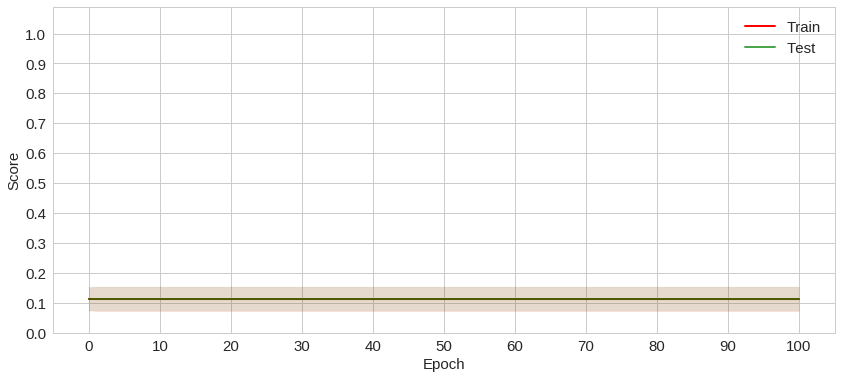

In [25]:
plot_mean_acc(history)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

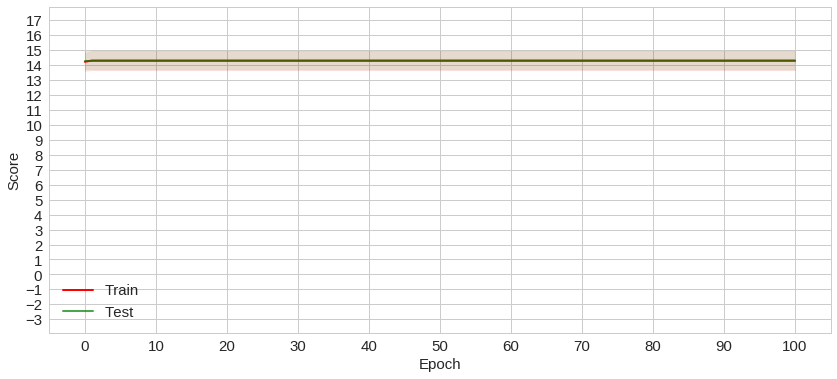

In [27]:
plot_mean_loss(history)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,15.9))
    plt.show()

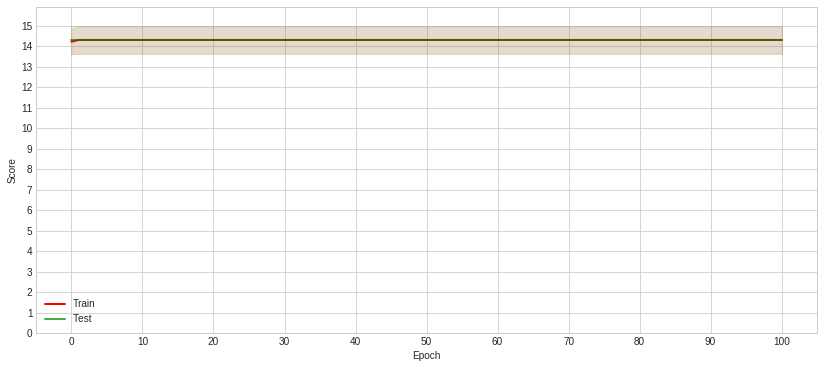

In [3]:
plot_mean_loss(history)